In [12]:
import numpy as np
import torch
import mnist_reader
import matplotlib.pyplot as plt

In [28]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

In [13]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (60000, 784)
y_train: (60000,)
X_test: (10000, 784)
y_test: (10000,)


In [25]:
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [68]:
def visualize_sample():
    idx = 1
    for i in np.random.choice(60000, 10):
        img = X_train[i].reshape(28,28)
        cls_idx = y_train[i]
        plt.subplot(1, 10, idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[cls_idx])
        idx += 1
    plt.imshow(img)
    
def visualize_idx(idx, X, y):
    img = X[idx].reshape(28,28)
    cls_idx = y[idx]
    plt.imshow(img)
    plt.title(labels[cls_idx])
    plt.imshow(img)

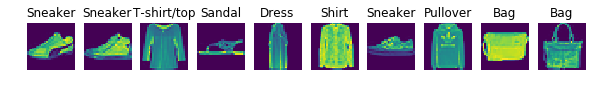

In [37]:
visualize_sample()

In [43]:
def train_val_split(X_train, y_train, val_size=0.05):
    # split train set into train and val set. split proportion will be according to val_size

    num_examples = len(y_train)
    val_indexes = np.random.choice(num_examples, int(num_examples * val_size), replace=False)

    X_val = X_train[val_indexes]
    y_val = y_train[val_indexes]

    # now get the remain indexes for train set
    mask = np.ones(num_examples, dtype=bool)
    mask[val_indexes] = False

    X_train = X_train[mask]
    y_train = y_train[mask]

    return X_train, X_val, y_train, y_val

In [44]:
 X_train, X_val, y_train, y_val = train_val_split(X_train, y_train)

In [81]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_val.shape)
print('y_valid:', y_val.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (57000, 784)
y_train: (57000,)
X_valid: (3000, 784)
y_valid: (3000,)
X_test: (10000, 784)
y_test: (10000,)


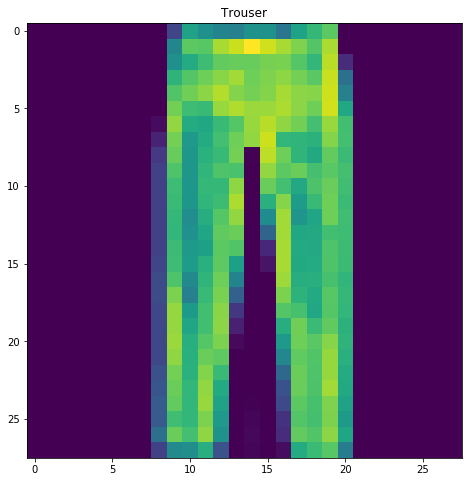

In [82]:
visualize_idx(16, X_train, y_train)

In [83]:
def data_loader(X, y):
    assert X.shape[0] == len(y)
    for i in range(len(y)):
        yield X[i], y[i]

In [75]:
train_loader = data_loader(X_train, y_train)

In [86]:
# create new dataset
subset_idx = 1
mask = (y_train == subset_idx)
y_train_subset = np.zeros_like(y_train)
y_train_subset[mask] = 1
mask = (y_val == subset_idx)
y_val_subset = np.zeros_like(y_val)
y_val_subset[mask] = 1
mask = (y_test == subset_idx)
y_test_subset = np.zeros_like(y_test)
y_test_subset[mask] = 1

W = np.random.random((784,1))